## Joint optimisation test

Train a lightning module to jointly optimise a subgrid forcing model while predicting the state of the system at some future timestep.


In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import copy
import numpy as np
import wandb

import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger
from sklearn.metrics import r2_score

## Import my modules
import pyqg_explorer.dataset.forcing_dataset as forcing_dataset     ## My dataset module
import pyqg_explorer.models.base_model as base_model                ## My lightning modules
import pyqg_explorer.util.divergence_dataset as divergence_dataset  ## Class used for online testing
import pyqg_explorer.generate_datasets as generate_datasets         ## Class used for online testing
import pyqg_explorer.util.powerspec as powerspec                    ## Module to plot the power spectrum of forcing fields
import pyqg_explorer.models.parameterizations as parameterizations  ## Module to include the trained CNN as a pyqg parameterization for online testing

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Available


In [3]:
lev="both"
forcing=1
seed=123
batch_size=64
input_channels=2
output_channels=2
activation="ReLU"
arch="cnn_theta"
epochs=12
subsample=None
normalise="proper"
beta_steps=5
beta_loss=0
conv_layers=8
save_path="/scratch/cp3759/pyqg_data/models"
save_name="cnn_theta_beta%d_betaloss%d_forcing%d_both_epoch%d.pt" % (beta_steps,beta_loss,forcing,epochs)
lr=0.0001

## Wandb config file
config={"lev":lev,
        "forcing":forcing,
        "seed":seed,
        "lr":lr,
        "batch_size":batch_size,
        "input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "save_name":save_name,
        "save_path":save_path,
        "arch":arch,
        "conv_layers":conv_layers,
        "beta_steps":beta_steps,
        "beta_loss":beta_loss,
        "epochs":epochs,
        "subsample":subsample,
        "normalise":normalise}

In [4]:
## Build dataset using the prescribed config
single_dataset=forcing_dataset.TimestepDataset('/scratch/cp3759/pyqg_data/sims/%d_step/all.nc' % config["beta_steps"],normalise=config["normalise"],seed=config["seed"],subsample=config["subsample"])

In [5]:
## Here we save the normalisation factors as part of the config - these are later passed to the torch model and saved
## It is important that these factors are saved along with a trained model, as the weights for a given model are
## connected to the normalisation used in it's training
config["q_mean_upper"]=single_dataset.q_mean_upper
config["q_mean_lower"]=single_dataset.q_mean_lower
config["q_std_upper"]=single_dataset.q_std_upper
config["q_std_lower"]=single_dataset.q_std_lower
config["s_mean_upper"]=single_dataset.s_mean_upper
config["s_mean_lower"]=single_dataset.s_mean_lower
config["s_std_upper"]=single_dataset.s_std_upper
config["s_std_lower"]=single_dataset.s_std_lower
config["training_fields"]=len(single_dataset.test_idx)
config["validation_fields"]=len(single_dataset.valid_idx)


## Copy the config, will be used to initialise the beta network
config_beta=copy.deepcopy(config)
config_beta["input_channels"]=config["input_channels"]*3
config_beta["save_name"]="cnn_beta%d_betaloss%d_both_epoch%d.pt" % (beta_steps,beta_loss,epochs)
config_beta["arch"]="cnn_beta"

In [6]:
## Construct training and validation dataloaders
train_loader = DataLoader(
    single_dataset,
    batch_size=config["batch_size"],
    sampler=SubsetRandomSampler(single_dataset.train_idx),
)
valid_loader = DataLoader(
    single_dataset,
    batch_size=config["batch_size"],
    sampler=SubsetRandomSampler(single_dataset.valid_idx),
)

In [7]:
model_beta=base_model.AndrewCNN(config_beta)
model_theta=base_model.AndrewCNN(config,model_beta)


#model_theta.to(device)
#model_beta.to(device)

## Store the number of learanble parameters
config["theta learnable parameters"]=sum(p.numel() for p in model_theta.parameters())

## Initialise wandb run - pass config dictionary storing the model parameters
wandb.init(project="pyqg_betanetwork", entity="chris-pedersen",config=config)
wandb.watch([model_theta,model_beta], log_freq=1)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chris-pedersen. Use `wandb login --relogin` to force relogin


[]

In [8]:
## Wandb logger will automatically track anything passed by `self.log` in the lightning module
## This is how you chose what variables to track on wandb during training (e.g. train and validation loss)
logger = WandbLogger()

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=7, ## Setting this to a low number just for testing purposes
    logger=logger,
    enable_progress_bar=False,
    )

## This calls the standard pytorch training/validation loop using the base_model.step() method from base_model.py
## see https://pytorch-lightning.readthedocs.io/en/stable/extensions/loops.html
trainer.fit(model_theta, train_loader, valid_loader)

/ext3/miniconda3/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | criterion  | MSELoss    | 0     
1 | model_beta | AndrewCNN  | 280 K 
2 | conv       | Sequential | 268 K 
------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.196     Total estimated model params size (MB)
/ext3/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The datalo

In [9]:
model_theta.save_model()
model_beta.save_model()

Model saved as /scratch/cp3759/pyqg_data/models/cnn_theta_beta5_betaloss0_forcing1_both_epoch12.pt
Model saved as /scratch/cp3759/pyqg_data/models/cnn_beta5_betaloss0_both_epoch12.pt


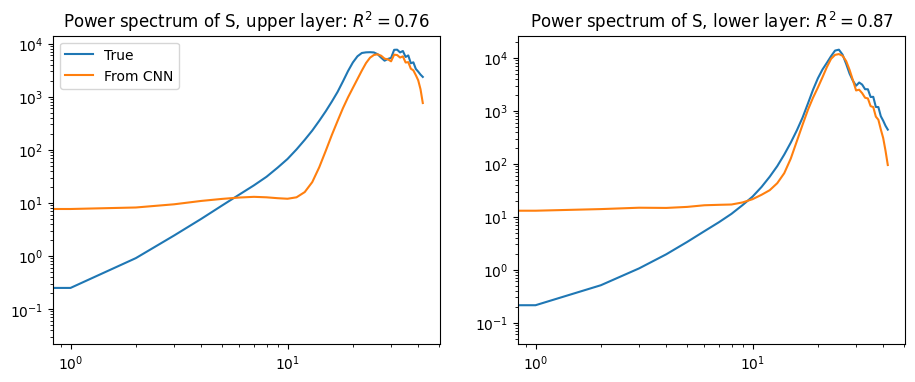

In [10]:
## Now do performance metrics

## Find R2 across entire validation set
## Do this on cpu, as gpu doesn't have enough
## memory to hold the entire validation set at once
x_maps=torch.tensor(()).to("cpu")
y_true=torch.tensor(()).to("cpu")
y_pred=torch.tensor(()).to("cpu")

model_theta.eval()
model_theta.to("cpu")
model_beta.to("cpu")

for i, data in enumerate(valid_loader, 0):
    ## x_data is ordered in [pv, dqdt, s]
    x_data, y_data = data
    ## First network
    y_hat = model_theta(x_data[:,0:2,:,:]) ## Takes in PV, outputs S
    
    x_data_cpu=x_data.to("cpu")
    y_hat_cpu=y_hat.to("cpu")
    
    ## Delete to try and minimise memory usage
    del x_data
    del y_hat
    
    x_maps=torch.cat((x_maps,x_data_cpu[:,0:2,:,:]),dim=0)
    y_true=torch.cat((y_true,x_data_cpu[:,4:6,:,:]),dim=0)
    y_pred=torch.cat((y_pred,y_hat_cpu),dim=0)
## Convert validation fields to numpy arrays
x_np=x_maps.squeeze().cpu().detach().numpy()
y_np=y_true.squeeze().cpu().detach().numpy()
y_pred_np=y_pred.squeeze().cpu().detach().numpy()

## Estimate R2
r2_upper=r2_score(y_np[:,0,:,:].flatten(),y_pred_np[:,0,:,:].flatten())
r2_lower=r2_score(y_np[:,1,:,:].flatten(),y_pred_np[:,1,:,:].flatten())

## Get power spectrum from validation set
power_true_upper=[]
power_pred_upper=[]
power_true_lower=[]
power_pred_lower=[]

for aa in range(len(x_np)):
    power_true_upper.append(powerspec.get_power_spectrum(y_np[aa][0]))
    power_pred_upper.append(powerspec.get_power_spectrum(y_pred_np[aa][0]))
    power_true_lower.append(powerspec.get_power_spectrum(y_np[aa][1]))
    power_pred_lower.append(powerspec.get_power_spectrum(y_pred_np[aa][1]))
    
power_true_upper_mean=np.mean(np.stack(power_true_upper,axis=1),axis=1)
power_pred_upper_mean=np.mean(np.stack(power_pred_upper,axis=1),axis=1)
power_true_upper_err=np.std(np.stack(power_true_upper,axis=1),axis=1)
power_pred_upper_err=np.std(np.stack(power_pred_upper,axis=1),axis=1)

power_true_lower_mean=np.mean(np.stack(power_true_lower,axis=1),axis=1)
power_pred_lower_mean=np.mean(np.stack(power_pred_lower,axis=1),axis=1)
power_true_lower_err=np.mean(np.stack(power_true_lower,axis=1),axis=1)
power_pred_lower_err=np.mean(np.stack(power_pred_lower,axis=1),axis=1)

fig, axs = plt.subplots(1, 2,figsize=(11,4))
axs[0].set_title(r"Power spectrum of S, upper layer: $R^2=%.2f$" % r2_upper )
axs[0].loglog(power_true_upper_mean,label="True")
axs[0].loglog(power_pred_upper_mean,label="From CNN")
axs[0].legend()

axs[1].set_title(r"Power spectrum of S, lower layer: $R^2=%.2f$" % r2_lower )
axs[1].loglog(power_true_lower_mean,label="True")
axs[1].loglog(power_pred_lower_mean,label="From CNN")

## Upload this figure to wandb
figure_power=wandb.Image(fig)
wandb.log({"Power spectrum": figure_power})

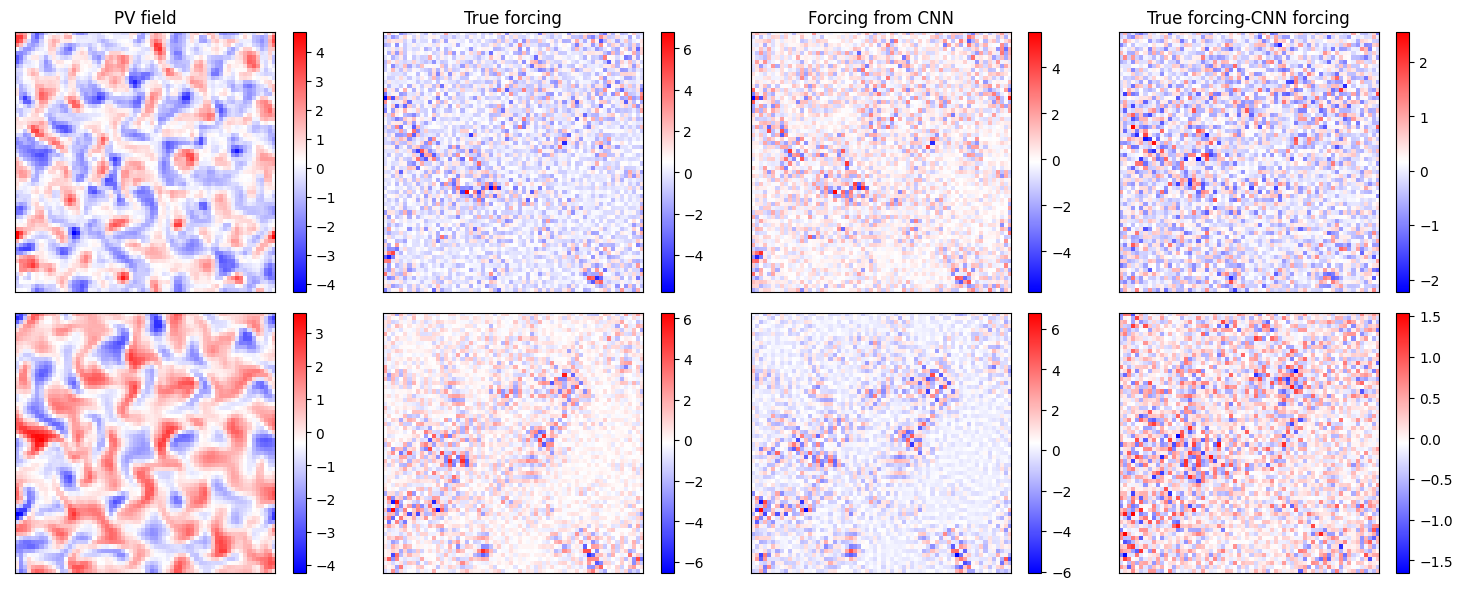

In [11]:
## Plot the truth and predicted subgrid forcing for a randomly chosen map
map_index=2

fig, axs = plt.subplots(2, 4,figsize=(15,6))
ax=axs[0][0].imshow(x_np[map_index][0], cmap='bwr')
fig.colorbar(ax, ax=axs[0][0])
axs[0][0].set_xticks([]); axs[0][0].set_yticks([])
axs[0][0].set_title("PV field")

ax=axs[0][1].imshow(y_np[map_index][0], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[0][1])
axs[0][1].set_xticks([]); axs[0][1].set_yticks([])
axs[0][1].set_title("True forcing")

ax=axs[0][2].imshow(y_pred_np[map_index][0], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[0][2])
axs[0][2].set_xticks([]); axs[0][2].set_yticks([])
axs[0][2].set_title("Forcing from CNN")

ax=axs[0][3].imshow(y_np[map_index][0]-y_pred_np[map_index][0], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[0][3])
axs[0][3].set_xticks([]); axs[0][3].set_yticks([])
axs[0][3].set_title("True forcing-CNN forcing")
fig.tight_layout()

ax=axs[1][0].imshow(x_np[map_index][1], cmap='bwr')
fig.colorbar(ax, ax=axs[1][0])
axs[1][0].set_xticks([]); axs[1][0].set_yticks([])

ax=axs[1][1].imshow(y_np[map_index][1], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[1][1])
axs[1][1].set_xticks([]); axs[1][1].set_yticks([])

ax=axs[1][2].imshow(y_pred_np[map_index][1], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[1][2])
axs[1][2].set_xticks([]); axs[1][2].set_yticks([])

ax=axs[1][3].imshow(y_np[map_index][1]-y_pred_np[map_index][1], cmap='bwr', interpolation='none')
fig.colorbar(ax, ax=axs[1][3])
axs[1][3].set_xticks([]); axs[1][3].set_yticks([])
fig.tight_layout()

figure_fields=wandb.Image(fig)
wandb.log({"Random fields": figure_fields})

INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 5.92e-04, CFL: 0.235
INFO: Step: 1000, Time: 3.60e+06, KE: 5.62e-04, CFL: 0.047
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 5.92e-04, CFL: 0.235
INFO: Step: 1000, Time: 3.60e+06, KE: 5.81e-04, CFL: 0.045
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 6.13e-04, CFL: 0.203
INFO: Step: 1000, Time: 3.60e+06, KE: 5.90e-04, CFL: 0.044
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 6.13e-04, CFL: 0.203
INFO: Step: 1000, Time: 3.60e+06, KE: 6.03e-04, CFL: 0.046
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 5.70e-04, CFL: 0.231
INFO: Step: 1000, Time: 3.60e+06, KE: 5.50e-04, CFL: 0.055
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 5.70e-04, CFL: 0.231
INFO: Step: 1000, Time: 3.60e+06, KE: 5

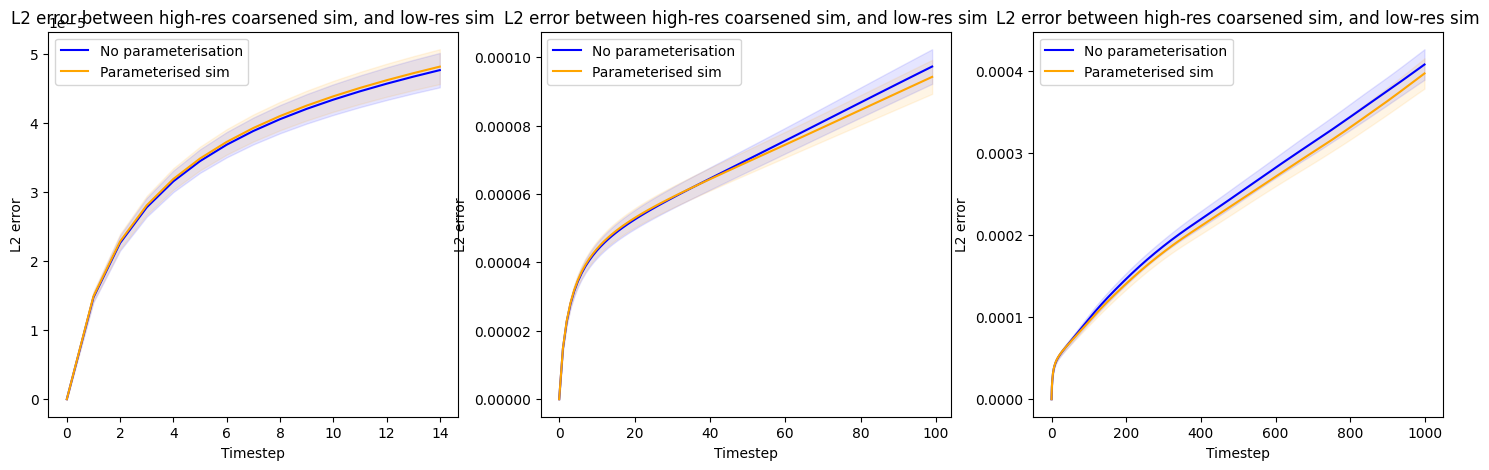

In [12]:
div_fig=divergence_dataset.test_model_divergence(model_theta)
div_fig=wandb.Image(div_fig)
wandb.log({"Divergence figure": div_fig})
## The red stuff is just pyqg logging output

INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 3.55e-07, CFL: 0.006
INFO: Step: 2000, Time: 7.20e+06, KE: 3.99e-07, CFL: 0.006
INFO: Step: 3000, Time: 1.08e+07, KE: 4.96e-07, CFL: 0.006
INFO: Step: 4000, Time: 1.44e+07, KE: 6.65e-07, CFL: 0.006
INFO: Step: 5000, Time: 1.80e+07, KE: 9.87e-07, CFL: 0.006
INFO: Step: 6000, Time: 2.16e+07, KE: 1.76e-06, CFL: 0.007
INFO: Step: 7000, Time: 2.52e+07, KE: 3.85e-06, CFL: 0.008
INFO: Step: 8000, Time: 2.88e+07, KE: 9.21e-06, CFL: 0.009
INFO: Step: 9000, Time: 3.24e+07, KE: 2.15e-05, CFL: 0.011
INFO: Step: 10000, Time: 3.60e+07, KE: 4.06e-05, CFL: 0.012
INFO: Step: 11000, Time: 3.96e+07, KE: 5.26e-05, CFL: 0.014
INFO: Step: 12000, Time: 4.32e+07, KE: 5.35e-05, CFL: 0.015
INFO: Step: 13000, Time: 4.68e+07, KE: 5.66e-05, CFL: 0.016
INFO: Step: 14000, Time: 5.04e+07, KE: 6.24e-05, CFL: 0.017
INFO: Step: 15000, Time: 5.40e+07, KE: 7.20e-05, CFL: 0.019
INFO: Step: 16000, Time: 5.76e+07, KE: 8.56e-05, CFL: 0.020
INFO: Step: 17000, Time

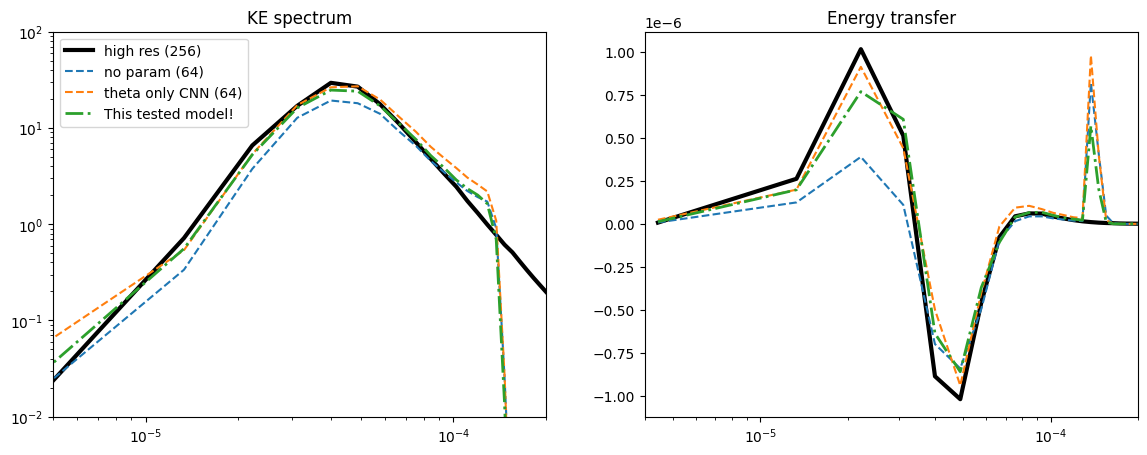

In [15]:
## Online test!!
parameterization=parameterizations.Parameterization(model_theta)
## Implement the model trained in this script as a pyqg parameterization
ds = generate_datasets.generate_dataset(parameterization=parameterization)

## Load pre-run reference sims for comparison
low_res=xr.open_dataset('/scratch/cp3759/pyqg_data/sims/online_test_reference_sims/test_sim_641.nc')
high_res=xr.open_dataset('/scratch/cp3759/pyqg_data/sims/online_test_reference_sims/test_sim_2561.nc')
theta_only=xr.open_dataset('/scratch/cp3759/pyqg_data/sims/online_test_reference_sims/test_sim_64_thetaonly1.nc')

fig, axs = plt.subplots(1, 2,figsize=(14,5))
axs[0].set_title("KE spectrum")
axs[0].loglog(high_res.ispec_k.data,high_res.ispec_KEspec_avegd.data,label="high res (256)",color="black",lw=3)
axs[0].loglog(low_res.ispec_k.data,low_res.ispec_KEspec_avegd.data,label="no param (64)",linestyle="dashed")
axs[0].loglog(theta_only.ispec_k.data,theta_only.ispec_KEspec_avegd.data,label="theta only CNN (64)",linestyle="dashed")
axs[0].loglog(ds.ispec_k.data,ds.ispec_KEspec_avegd.data,label="This tested model!",linestyle="-.",lw=2)
axs[0].set_ylim(1e-2,1e2)
axs[0].set_xlim(5e-6,2e-4)
axs[0].legend()

axs[1].set_title("Energy transfer")
axs[1].plot(high_res.ispec_k.data,high_res.ispec_energy_transfer.data,label="high res (256)",lw=3,color="black")
axs[1].plot(low_res.ispec_k.data,low_res.ispec_energy_transfer.data,label="no param (64)",linestyle="dashed")
axs[1].plot(theta_only.ispec_k.data,theta_only.ispec_energy_transfer.data,label="theta only CNN (64)",linestyle="dashed")
axs[1].plot(ds.ispec_k.data,ds.ispec_energy_transfer.data,label="This tested model!",linestyle="-.",lw=2)
axs[1].set_xscale("log")
axs[1].set_xlim(4e-6,2e-4)

online_fig=wandb.Image(fig)
wandb.log({"Online figure": online_fig})


In [16]:
wandb.run.summary["r2_upper"]=r2_upper
wandb.run.summary["r2_lower"]=r2_lower
wandb.finish()


epoch,▁▁▂▂▃▃▅▅▆▆▇▇██
train_beta_loss,▁▁▁▁▁▁▁
train_theta_loss,█▃▂▂▁▁▁
train_total_loss,█▃▂▂▁▁▁
trainer/global_step,▁▁▂▂▃▃▄▄▆▆▇▇██
valid_beta_loss,▁▁▁▁▁▁▁
valid_theta_loss,█▅▃▂▂▁▁
valid_total_loss,█▅▃▂▂▁▁
epoch,6
r2_lower,0.86771
r2_upper,0.76274
